In [1]:
import numpy as np
import cv2
from skimage.segmentation import clear_border
import matplotlib.pyplot as plt

from bubblekicker.bubblekicker import (BubbleKicker, batchbubblekicker, bubble_properties_calculate, 
                                       _bubble_properties_filter, bubble_properties_plot)

from bubblekicker.pipelines import CannyPipeline, AdaptiveThresholdPipeline
import matplotlib
from matplotlib import pyplot as plt
import os
import seaborn as sns
import sys
%matplotlib inline

<b>Questo notebook vuole ottimizzare l'analisi delle immagini di granuli aerobici</b> 

<b>usa la variabile path, in questo modo, quando lo usi te, basta che tu tolga il commento $#$ dalla tua e tu lo metta alla mia riga<\b>

come vedi sotto, facendo semplicemente la somma di queste stringhe riesci a costruire la destinazione dell'immagine

# Carica l'immagine

In [2]:
#path = r'C:\Users\Serena\Desktop' # PC Serena
path = r'C:\Users\Giacomo\Documents\gitRepos\Serena\shared_nbks' # PC Giacomo
path + '\\' + 'classe 5.JPG'

'C:\\Users\\Giacomo\\Documents\\gitRepos\\Serena\\shared_nbks\\classe 5.JPG'

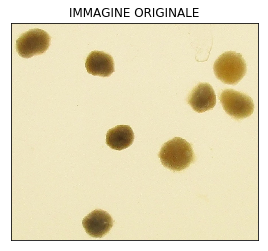

In [3]:
img = cv2.imread(path + '\\' + 'classe 5.JPG')

# divide l'immagine nei layer base
img_B,img_G,img_R = cv2.split(img)

#crea una nuova variabile con i layer reimpostati
img2 = cv2.merge((img_R,img_G,img_B))

# salva l'immagine originale ricomposta
plt.imshow(img2), plt.xticks([]), plt.yticks([]), plt.grid('on'), plt.title('IMMAGINE ORIGINALE'); 
# plt.savefig(path + '\\'+ 'OriginalRGB.jpg',dpi=500)

<b>sotto si vede che il canale BLU da' il miglior contrasto<b>

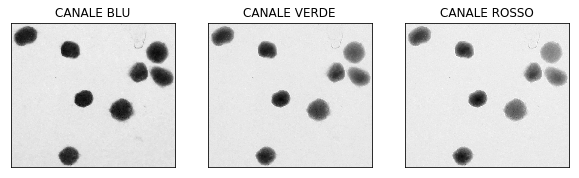

In [4]:
#mostra e salva i diversi canali
plt.figure(figsize=(10, 10))
plt.subplot(3,3,1),plt.imshow(img_B, cmap='gray'), plt.title('CANALE BLU'), plt.xticks([]), plt.yticks([]); 
plt.subplot(3,3,2), plt.imshow(img_G, cmap='gray'), plt.title('CANALE VERDE'), plt.xticks([]), plt.yticks([]); 
plt.subplot(3,3,3), plt.imshow(img_R, cmap='gray'), plt.title('CANALE ROSSO'), plt.xticks([]), plt.yticks([]); 
# plt.savefig(path + '\\' + 'channels.jpg',dpi=500)

Dopo aver scelto il canale che sembra migliore si procede con la binarizzazione dell'immagine. La scelta del canle migliore e' importante per facilitare proprio il prossimo step.

# Elaborazione immagine

Aggiustando un pochino i parametri sembra di riuscire meglio a catturare bene i granuli (valori originali 91 e 15)
Inoltre si determinano meglio i bordi e si riesce a perdere roba troppo piccola (bisogna pero' provare se funziona anche con  granuli piu' piccoli)

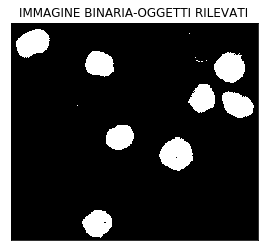

In [17]:
# provvede ad un riconoscimento adattivo dei contorni
binImg = cv2.adaptiveThreshold(img_B, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 201, 25)
plt.imshow(binImg, cmap='Greys',  interpolation='nearest'), plt.title('IMMAGINE BINARIA-OGGETTI RILEVATI'), 
plt.xticks([]), plt.yticks([]), plt.grid('on');  
# plt.savefig(path + '\\' + 'oggetti_rilevati.jpg',dpi=500)

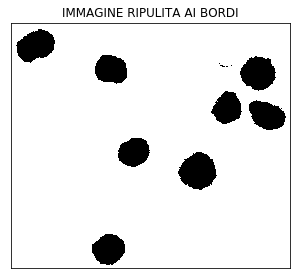

In [18]:
dst_inv = cv2.bitwise_not(binImg) 
img_clb = clear_border(dst_inv, buffer_size=5, bgval=1)
plt.figure(figsize=(5,5))
plt.imshow(img_clb, cmap='Greys',  interpolation='nearest'), plt.title('IMMAGINE RIPULITA AI BORDI'), 
plt.grid('on'), plt.xticks([]), plt.yticks([]);
# plt.savefig(path + '\\' + 'IMMAGINE RIPULITA AI BORDI.jpg', dpi=500)

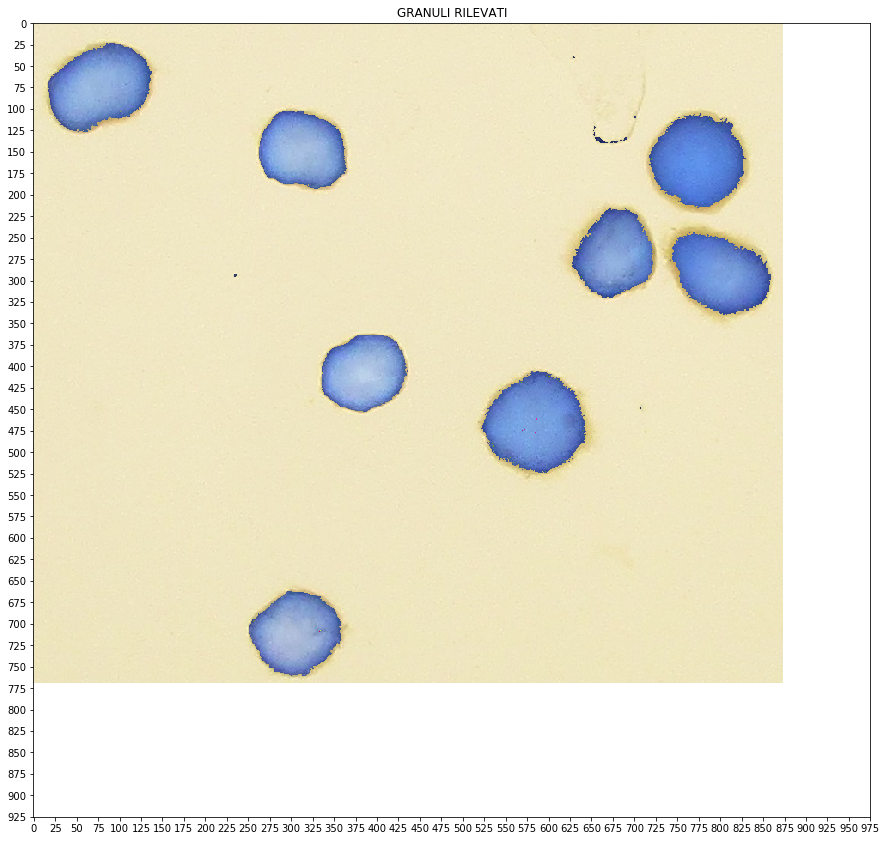

In [20]:
img_outl = cv2.merge((img_R * img_clb, img_G * img_clb, img_B * img_clb))
plt.figure(figsize=(15, 15));
plt.imshow(img_G * img_clb), plt.title('GRANULI RILEVATI')
plt.imshow(img_outl), plt.title('GRANULI RILEVATI')
plt.xticks([25*k for k in range(0,40)])
plt.yticks([25*k for k in range(0,38)]);
# plt.savefig(path + '\\' + 'GRANULI_RILEVATI.jpg',dpi=500)


A questo punto si passa subito a calcolare le proprieta' dei granuli. 
<p><b> DOMANDA: hai deciso di non fare lo step di erodere e dilatare i bordi di proposito? <b\>

In [33]:
# calcola le proprieta' dei blob nell'immagine
marker_image, props = bubble_properties_calculate(img_clb,rules={'convexity': {'min':1.9 }, 
                                                                 'circularity_reciprocal': {'max': 5, 'min': 0.2}});

{'max': 5, 'min': 0.2}
{'min': 1.9}


questa e' l'immagine che deriva dal passaggio di calcolo delle proprieta'
##### si vede che la roba piccola e' stata eliminata, sono rimasti solo i granuloni e sembrano tutti sopra i 2mm

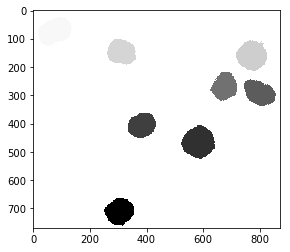

In [34]:
plt.imshow(marker_image, cmap='gray_r');

In [37]:
# aggiunge colonna con misura effettiva dei granuli
props['equivalent_diameter_mm'] = props['equivalent_diameter']/49

In [35]:
props.head()

,area,centroid,convex_area,equivalent_diameter,perimeter,convexity,circularity_reciprocal
label,,,,,,,
1,8825,"(74.098470255, 76.7716713881)",9301,106.001599,418.853860,21.069401,1.581978
6,7238,"(147.965874551, 312.815004145)",7488,95.998478,346.391919,20.895407,1.319189
7,8915,"(159.807739764, 773.575659002)",9463,106.540746,446.510714,19.965926,1.779642
20,6903,"(269.140084021, 676.41692018)",7211,93.750587,382.019336,18.069766,1.682376
23,7755,"(291.374725983, 800.181044487)",8229,99.367865,445.753355,17.397513,2.038908


In [43]:
h, b = np.histogram(props['equivalent_diameter'], bins=20)

In [44]:
b

array([  93.75058708,   94.742068  ,   95.73354891,   96.72502983,
         97.71651075,   98.70799167,   99.69947259,  100.6909535 ,
        101.68243442,  102.67391534,  103.66539626,  104.65687718,
        105.64835809,  106.63983901,  107.63131993,  108.62280085,
        109.61428177,  110.60576268,  111.5972436 ,  112.58872452,
        113.58020544])

In [45]:
h

array([2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1])

In [46]:
props['equivalent_diameter']

label
1     106.001599
6      95.998478
7     106.540746
20     93.750587
23     99.367865
27     93.750587
29    113.580205
36     98.181957
Name: equivalent_diameter, dtype: float64

(None, <matplotlib.text.Text at 0xcfb1e50>)

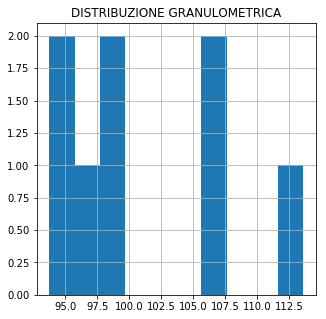

In [47]:
fig = plt.figure(figsize=(5,5));
props['equivalent_diameter_mm'].hist()
plt.grid('on'),plt.title('DISTRIBUZIONE GRANULOMETRICA')
# plt.savefig(path + '\\' + 'distribuzione_granulometrica.jpg',dpi=500)

Plotta il centroid

In [15]:
# con questo archivi la posizione x e y e la classe di ogni centroide in tre variabili (x,y e cls)
x = []; y = []; cls = []
for i in props['centroid'].reset_index().index:
    x = np.append(x, props['centroid'].values[i][1])
    y = np.append(y, props['centroid'].values[i][0])
    cls = np.append(cls, props['classe'].values[i])

KeyError: 'classe'

IndexError: list index out of range

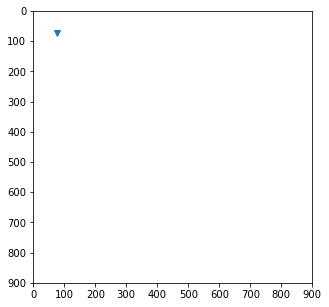

In [16]:
# plotta in automatico la posizione del centroide e ci mette il valore 
fig, ax1 = plt.subplots(figsize=(5,5)) 
ax1.plot(x,y, 'v')
ax1.set_xlim(0,900) # allarga i limiti della figura per far vedere bene anche i punti sul bordo
ax1.set_ylim(0,900) 
ax1.invert_yaxis()  # inverte l'asse y per metterlo come viene messo per visualizzare la figura
for i in np.arange(len(x)):
    ax1.annotate(str(int(cls[i])), xy=(x[i], y[i]), xytext=(x[i]+30, y[i]+30))
                #, arrowprops=dict(facecolor='black', shrink=0.05),) # se ci vuoi mettere anche una freccia togli questo commento

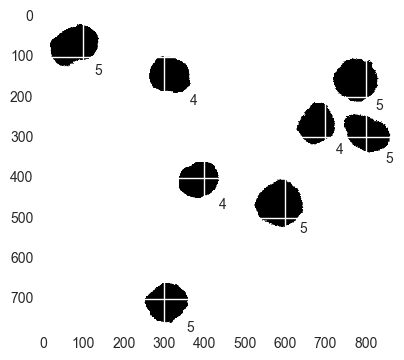

In [210]:
fig, ax1 = plt.subplots()
# il maggiore di zero serve per fare tutti i pippoli neri, se lo levi diventa scala di grigi
ax1.imshow(marker_image>0, cmap='binary', interpolation='bilinear'); 
for i in np.arange(len(x)):
    ax1.annotate(str(int(cls[i])), xy=(x[i], y[i]), xytext=(x[i]+50, y[i]+70)); # possibile futuro miglioramento sara' visualizzare 